Calculate the topographic form stress.

In [2]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import interpolate

Read bottom index.

In [3]:
bottom = nc.Dataset('/short/v45/lxy581/mom6/diag/find_bottom_index.nc','r')

bot_u = bottom.variables['bot_u'][:,:]
bot_v = bottom.variables['bot_v'][:,:]
bot_c = bottom.variables['bot_c'][:,:]
bot_t = bottom.variables['bot_t'][:,:]

Read wind stress from input file.

In [4]:
forcing = nc.Dataset('/short/v45/lxy581/mom6/input/exp1_w2/forcing.nc','r') 
taux = forcing.variables['taux'][:,0]

Read topography

In [5]:
topog = nc.Dataset('/short/v45/lxy581/mom6/input/exp1_w2/topog.nc','r')

Read output - exp1w2, C$_{d}$ = 0.003, $\tau_x$ = 0.2 N m$^{-2}$.

In [6]:
data12 = nc.Dataset('/g/data1/v45/lxy581/payu/archive/exp1_w2/output015/prog.nc','r')

Basic variables:

In [7]:
xh   = data12.variables['xh'][:]
yh   = data12.variables['yh'][:]
xq   = data12.variables['xq'][:]
yq   = data12.variables['yq'][:]
zl   = data12.variables['zl'][:]
time = data12.variables['Time'][:]
pbo12_xy = np.nanmean(data12.variables['pbo'][:,:,:],axis=0)
nt   = np.size(time)
ny   = np.size(yh)
nx   = np.size(xh)
nz   = np.size(zl)
dx   = 1e+4 # 10km
Lx   = 4e+6 # 4000km

Intermediate variables:

In [8]:
h_u     = np.full((ny,nx),np.nan)
h_t     = np.full((ny,nx),np.nan)
h_c     = np.full((ny,nx),np.nan)
dhdx_u  = np.full((ny,nx),np.nan)
dhdx_t  = np.full((ny,nx),np.nan)
dhdx_v  = np.full((ny,nx),np.nan)
u12_bot = np.full((ny,nx),np.nan)
v12_bot = np.full((ny,nx),np.nan)
TFS12   = np.full((ny,nx),np.nan)

h_t is the depth at T(xh,yh) points.

In [9]:
h_t = - topog.variables['depth'][:,:]  

Interpolate to get depth at u(xq,yh), v(xh,yq), corner(xq,yq) points. Corner points are where PV is. 

In [10]:
f = interpolate.interp2d(xh,yh,h_t,kind='cubic')
h_u = f(xq,yh)
h_v = f(xh,yq)
h_c = f(xq,yq)

Use depth at u(xq,yh) points to calculate $\frac{\partial h}{\partial x}$ at T(xh,yh) points.

In [11]:
dhdx_t[:,0] = (h_u[:,0]-h_u[:,nx-1])/dx
for i in xrange(nx-1):
    dhdx_t[:,i+1] = (h_u[:,i+1] - h_u[:,i])/dx    

Use depth at T(xh,yh) points to calculate $\frac{\partial h}{\partial x}$ at u(xq,yh) points.

In [12]:
dhdx_u[:,nx-1] = (h_t[:,0]-h_t[:,nx-1])/dx
for i in xrange(nx-2):
    dhdx_u[:,i] = (h_t[:,i+1] - h_t[:,i])/dx    

Use depth at corner(xq,yq) points to calculate $\frac{\partial h}{\partial x}$ at v(xh,yq) points.

In [13]:
dhdx_v[:,0] = (h_c[:,0]-h_c[:,nx-1])/dx
for i in xrange(nx-1):
    dhdx_v[:,i+1] = (h_c[:,i+1] - h_c[:,i])/dx    

Calculate topographic form stress:

In [14]:
pbo12 = pbo12_xy * dhdx_t
pbo12_yh = np.nansum(pbo12,axis=1) * dx

Quadratic bottom frictional drag

In [16]:
for j in xrange(ny):
    for i in xrange(nx):
        u12_bot[j,i] = data12.variables['u'][-1,bot_u[j,i],j,i]

cd12 = 0.003
rho0 = 1035.0
bfr12 = rho0*cd12*u12_bot**2*dx 

In [19]:
bfr12_yh = np.nansum(bfr12,axis=1)

Plot

In [17]:
%matplotlib inline

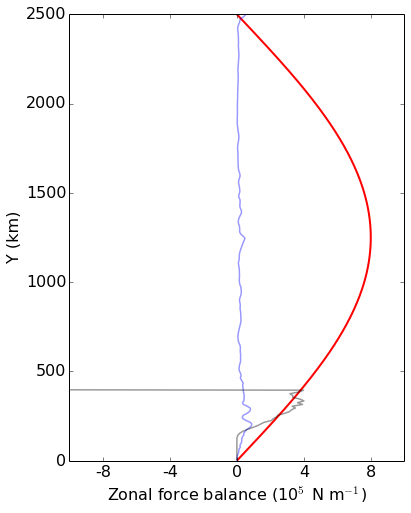

In [20]:
plt.figure(1,figsize=(6,8))
plt.plot(taux*Lx,yh,linewidth=2.0,color='r',label=r'$\tao_{w}$')
plt.plot(bfr12_yh,yh,linewidth=1.5,color='b',alpha=0.4,label=r'$\tao_{b}$')
plt.plot(pbo12_yh,yh,linewidth=1.5,color='k',alpha=0.4,label='TFS')
plt.xlim(-1e+6,1e+6)
plt.ylim(-1250,1250)
plt.gca().set_xticks(np.arange(-8e+5, 8e+5 + 4e+5, 4e+5))
plt.gca().set_xticklabels(['-8','-4','0','4','8'])
plt.gca().set_yticks(np.arange(-1250,1250 + 500,500))
plt.gca().set_yticklabels(['0','500','1000','1500','2000','2500'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Zonal force balance (10$^{5}$ N m$^{-1}$)',fontsize=16)
plt.ylabel('Y (km)',fontsize=16)
plt.show()

Check results

In [21]:
print np.nanmax(pbo12_yh)

400350.551152


In [22]:
print np.nanmin(pbo12_yh)

-300763451.974


In [23]:
print np.nanmean(pbo12_yh)

-41121611.1213
